# Survey of fuel prices in Brazil / Import & Clean, EDA

#### Background
Time series analysis of fuel prices by geographic region in Brazil. This dataset was made available through [Kaggle](https://www.kaggle.com/matheusfreitag/gas-prices-in-brazil) from the [Agência Nacional do Petróleo, Gás Natural e Biocombustíveis](http://www.anp.gov.br/precos-e-defesa-da-concorrencia/precos/levantamento-de-precos/serie-historica-do-levantamento-de-precos-e-de-margens-de-comercializacao-de-combustiveis) and comprises weekly reports of gas, diesel and other fuel prices used in different parts of Brazil.

Note: In this notebook the words "fuel" and "product" are used interchangeably.

#### Structure
This analysis consists of 2 notebooks:
* *0.1-import-clean-eda* - Import & Cleaning, Exploratory Data Analysis
* *0.2-geospatial-analysis* - Geospatial Analysis

#### Questions
The geospatial analysis seeks to answer the 3 questions on the Kaggle website:
1. How did gas prices change in different regions of Brazil?
2. Within a region, which states increased their prices?
3. Which states are the cheapest (or most expensive) for different types of fuels?


## 1. Import & Clean Data

In [1]:
import os
import sys
sys.path[0] = '../'

# Import libraries
from IPython.display import display, HTML # Display functions
import numpy as np
import pandas as pd

# Visualization libraries
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_palette("colorblind") 
sns.set_style("whitegrid")
fig_path = sys.path[0] + 'figures/' # path for saving figures

# Set Pandas display options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
# Read data
path = "../data/raw/2004-2019.tsv.zip"

df = pd.read_csv(path, sep='\t',parse_dates=True)
df.head()

,Unnamed: 0,DATA INICIAL,DATA FINAL,REGIÃO,ESTADO,PRODUTO,NÚMERO DE POSTOS PESQUISADOS,UNIDADE DE MEDIDA,PREÇO MÉDIO REVENDA,DESVIO PADRÃO REVENDA,PREÇO MÍNIMO REVENDA,PREÇO MÁXIMO REVENDA,MARGEM MÉDIA REVENDA,COEF DE VARIAÇÃO REVENDA,PREÇO MÉDIO DISTRIBUIÇÃO,DESVIO PADRÃO DISTRIBUIÇÃO,PREÇO MÍNIMO DISTRIBUIÇÃO,PREÇO MÁXIMO DISTRIBUIÇÃO,COEF DE VARIAÇÃO DISTRIBUIÇÃO,MÊS,ANO
0,0,2004-05-09,2004-05-15,CENTRO OESTE,DISTRITO FEDERAL,ETANOL HIDRATADO,127,R$/l,1.288,0.016,1.19,1.350,0.463,0.012,0.825,0.11,0.4201,0.9666,0.133,5,2004
1,1,2004-05-09,2004-05-15,CENTRO OESTE,GOIAS,ETANOL HIDRATADO,387,R$/l,1.162,0.114,0.89,1.449,0.399,0.098,0.763,0.088,0.5013,1.05,0.115,5,2004
2,2,2004-05-09,2004-05-15,CENTRO OESTE,MATO GROSSO,ETANOL HIDRATADO,192,R$/l,1.389,0.097,1.18,1.760,0.419,0.070,0.97,0.095,0.5614,1.161,0.098,5,2004
3,3,2004-05-09,2004-05-15,CENTRO OESTE,MATO GROSSO DO SUL,ETANOL HIDRATADO,162,R$/l,1.262,0.070,1.09,1.509,0.432,0.055,0.83,0.119,0.5991,1.22242,0.143,5,2004
4,4,2004-05-09,2004-05-15,NORDESTE,ALAGOAS,ETANOL HIDRATADO,103,R$/l,1.181,0.078,1.05,1.400,0.24,0.066,0.941,0.077,0.7441,1.0317,0.082,5,2004


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106823 entries, 0 to 106822
Data columns (total 21 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Unnamed: 0                     106823 non-null  int64  
 1   DATA INICIAL                   106823 non-null  object 
 2   DATA FINAL                     106823 non-null  object 
 3   REGIÃO                         106823 non-null  object 
 4   ESTADO                         106823 non-null  object 
 5   PRODUTO                        106823 non-null  object 
 6   NÚMERO DE POSTOS PESQUISADOS   106823 non-null  int64  
 7   UNIDADE DE MEDIDA              106823 non-null  object 
 8   PREÇO MÉDIO REVENDA            106823 non-null  float64
 9   DESVIO PADRÃO REVENDA          106823 non-null  float64
 10  PREÇO MÍNIMO REVENDA           106823 non-null  float64
 11  PREÇO MÁXIMO REVENDA           106823 non-null  float64
 12  MARGEM MÉDIA REVENDA          

### 1.1 Fix column labels

A glance at the raw data shows that:
* Columns are in Portuguese and will be translated into English for convenience
* Column names will be cleaned and standardized
* Dates will be converted to Datetime objects
* Unecessary columns will be removed

In [4]:
# Translate column names to English
df.columns = ["Unnamed:_0", 
"Analysis_Date",
"Last day of analyses of week",
"Macroregion",
"State",
"Product",
"No of Gas Stations Analyzed",
"Measurement unit",
"Mean Price",
"Std Dev",
"Min Price",
"Max Price",
"Mean Price Margin",
"Coefficient of variation",
"Mean Dist Price",
"Distribution Std Dev",
"Distribution Min Price",
"Distribution Max Price",
"Distribution Coefficient of Variation",
"Month",
"Year"]

# Replace whitespace with underscore
df.columns = df.columns.str.replace(" ", "_")
df.columns = df.columns.str.replace("'", "")
df.columns = df.columns.str.replace("Distribution", "Dist")

# Convert datetime columns to datetime objects and rename
df["Analysis_Date"] = pd.to_datetime(df["Analysis_Date"])

### 1.2 Fix Values, Datatypes, and NULLs

Cleaning the dataset requires a specific strategy: 
* Correct inappropriate characters
* Address NULL values
* Convert datatypes

For this particular dataset:
* Fix inappropriate string characters in several columns that should be numeric
* Translate categories in the *Product* column
* Rename *Measurement_unit* categories
* Convert object types to category type

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106823 entries, 0 to 106822
Data columns (total 21 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   Unnamed:_0                     106823 non-null  int64         
 1   Analysis_Date                  106823 non-null  datetime64[ns]
 2   Last_day_of_analyses_of_week   106823 non-null  object        
 3   Macroregion                    106823 non-null  object        
 4   State                          106823 non-null  object        
 5   Product                        106823 non-null  object        
 6   No_of_Gas_Stations_Analyzed    106823 non-null  int64         
 7   Measurement_unit               106823 non-null  object        
 8   Mean_Price                     106823 non-null  float64       
 9   Std_Dev                        106823 non-null  float64       
 10  Min_Price                      106823 non-null  float64       
 11  

In [6]:
# Correct dtypes
float_columns = ['Mean_Price_Margin', 'Mean_Dist_Price', 'Dist_Std_Dev',
       'Dist_Min_Price', 'Dist_Max_Price',
       "Dist_Coefficient_of_Variation"]

# Replace "-" with 0 in order to convert to float
for column in float_columns:
    df[column] = df[column].str.replace("-", "0")

# Fill nulls and convert to float
df[float_columns] = df[float_columns].fillna(0).astype(float)

assert df[float_columns].dtypes.all() == np.float64

# Rename Product categories
products = {"ÓLEO DIESEL":"DIESEL", "GASOLINA COMUM":"PETROL", "GLP":"LPG", 
            "ETANOL HIDRATADO":"HYDROUS ETHANOL", "GNV":"NATURAL GAS", "ÓLEO DIESEL S10":"DIESEL S10"}

df["Product"] = df.Product.map(products)

# Rename Measurement_unit categories
units = {"R$/l":"liter", "R$/13Kg":"13kg", "R$/m3":"m3"}

df["Measurement_unit"] = df["Measurement_unit"].map(units)

# Convert objects to category
object_cols = df.select_dtypes(include='object').columns
df[object_cols] = df[object_cols].astype('category')

### 1.3 Transform Columns

New columns created:
* Price_Group - separating LPG from the other fuels for easier visualization
* Mean_Price_Norm - Normalized Mean_Price by fuel Product
* Year_Month - for time series plots

In [7]:
# Create Price Groups: Group 1 are liquid fuels plus Natural Gas, Group 2 is LPG
df['Price_Group'] = df.Measurement_unit.map({'liter':int(1), 'm3':int(1), '13kg':int(2)})

# Normalize Mean Price for each fuel group
normalizer = lambda x: (x - x.min()) / (x.max() - x.min())

# Normalize Prices for Price_Group_1: all fuels except LPG
df["Mean_Price_Norm_Price_Group_1"] = df[df.Price_Group==1].groupby("Product")["Mean_Price"].transform(normalizer)

# Normalize Prices for Price_Group_2: LPG
df["Mean_Price_Norm_Price_Group_2"] = df[df.Price_Group==2].groupby("Product")["Mean_Price"].transform(normalizer)

# Combine Price_Group columns into one column
df["Mean_Price_Norm"] = df["Mean_Price_Norm_Price_Group_1"].fillna(df["Mean_Price_Norm_Price_Group_2"])
df.drop(["Mean_Price_Norm_Price_Group_1", "Mean_Price_Norm_Price_Group_2"], axis=1, inplace=True)

# Create Year_Month column for time series plots
year_month = df.Year.astype(str) + "-" + df.Month.astype(str)
df["Year_Month"] = pd.to_datetime(year_month)

Double check that the values were correctly normalized:

In [8]:
# Check max/min values of each Product group to ensure that they were properly normalized
products = df.Product.unique().tolist()

for product in range(len(products)):
    mins = df[df.Product==products[product]]["Mean_Price_Norm"].min()
    maxs = df[df.Product==products[product]]["Mean_Price_Norm"].max()
    
    print(products[product])
    print(mins, maxs)

HYDROUS ETHANOL
0.0 1.0
PETROL
0.0 1.0
LPG
0.0 1.0
NATURAL GAS
0.0 1.0
DIESEL
0.0 1.0
DIESEL S10
0.0 1.0


### 1.4 Drop unnecessary columns

In [9]:
df.drop(['Unnamed:_0', 'Last_day_of_analyses_of_week'], axis = 1, inplace=True)

### 1.5 Save clean data to file

In [10]:
display(df.head())

# Save to clean data folder
df.to_csv('../data/processed/fuel_in_brazil_clean.csv', header=True, index=False)

,Analysis_Date,Macroregion,State,Product,No_of_Gas_Stations_Analyzed,Measurement_unit,Mean_Price,Std_Dev,Min_Price,Max_Price,Mean_Price_Margin,Coefficient_of_variation,Mean_Dist_Price,Dist_Std_Dev,Dist_Min_Price,Dist_Max_Price,Dist_Coefficient_of_Variation,Month,Year,Price_Group,Mean_Price_Norm,Year_Month
0,2004-05-09,CENTRO OESTE,DISTRITO FEDERAL,HYDROUS ETHANOL,127,liter,1.288,0.016,1.19,1.350,0.463,0.012,0.825,0.110,0.4201,0.96660,0.133,5,2004,1,0.141348,2004-05-01
1,2004-05-09,CENTRO OESTE,GOIAS,HYDROUS ETHANOL,387,liter,1.162,0.114,0.89,1.449,0.399,0.098,0.763,0.088,0.5013,1.05000,0.115,5,2004,1,0.107230,2004-05-01
2,2004-05-09,CENTRO OESTE,MATO GROSSO,HYDROUS ETHANOL,192,liter,1.389,0.097,1.18,1.760,0.419,0.070,0.970,0.095,0.5614,1.16100,0.098,5,2004,1,0.168698,2004-05-01
3,2004-05-09,CENTRO OESTE,MATO GROSSO DO SUL,HYDROUS ETHANOL,162,liter,1.262,0.070,1.09,1.509,0.432,0.055,0.830,0.119,0.5991,1.22242,0.143,5,2004,1,0.134308,2004-05-01
4,2004-05-09,NORDESTE,ALAGOAS,HYDROUS ETHANOL,103,liter,1.181,0.078,1.05,1.400,0.240,0.066,0.941,0.077,0.7441,1.03170,0.082,5,2004,1,0.112375,2004-05-01


## 2. Exploratory Data Analysis

The questions posed by this analysis can be answered with *Mean_Price*. The other numeric variables can be excluded with the exception of *Mean_Dist_Price* because of some interesting behavior we will look at. The columns included in this analysis will be:
* Analysis_Date
* Macroregion
* State
* Product
* No_of_Gas_Stations_Analyzed
* Measurement_unit
* Mean_Price
* Mean_Dist_Price
* Month
* Year
* Price_Group

In [11]:
# Drop columns
df.drop(['Std_Dev', 
         'Min_Price', 'Max_Price', 'Mean_Price_Margin', 
         'Coefficient_of_variation', 
         'Dist_Std_Dev', 'Dist_Min_Price', 'Dist_Max_Price', 
         'Dist_Coefficient_of_Variation'], axis = 1, inplace=True)

### 2.1 Helper Functions

#### count_plot( )

Vertical bar chart of counts.

In [12]:
def count_plot(column, df, title=None, xlabel=None, ylabel=None, rot=None, save_as=None):

    fig, ax = plt.subplots(figsize=(12,6))
    ax = sns.countplot(x=column, data=df)
    plt.title(title, fontsize=20)
    plt.xlabel(xlabel, fontsize=22)
    plt.ylabel(ylabel, fontsize=24)
    plt.xticks(rotation=rot, fontsize=20)
    plt.yticks(fontsize=16)
    plt.tight_layout()
    
    if save_as:
        plt.savefig(save_as, bbox_inches='tight')
    
    plt.show()

#### ecdf( ) 

Plots the empirical distribution function (ECDF) of a numeric column.

In [13]:
# Define ECDF function
def ecdf(data, column, title=None, color=None, save_as=None):
    n = len(data[column])
    x = np.sort(data[column])
    y = np.arange(1, n+1)/n
    
    # Plot
    plt.figure(figsize=(10,5))
    plt.plot(x, y, marker='.', linestyle='none', color=color)
    plt.title(title)
    plt.xlabel("{}".format(column))
    plt.ylabel("ECDF")
    
    if save_as:
        plt.savefig(save_as, bbox_inches='tight')
        
    plt.show()

#### ecdf_category( )

Plots multiple ECDFs by column category.

In [14]:
def ecdf_category(column, group, title=None, xlabel=None, save_as=None):

    # Create figure with ECDF plots for each fuel Mean Price 
    products = df[group].unique().tolist()

    # Group dataframe by Product and select Mean Price
    product_group = df.groupby(group)[column]

    # Set rows and columns
    ncols = int(3)
    nrows = int(len(products) / ncols if len(products) % 2 == 0 else (len(products) + 1) / ncols)
    

    # List of colors
    color = ["b", "y", "g", "m", "r", "c"]

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 10))

    # Index counter
    n = 0

    # Create subplots
    for row in range(nrows):
        for col in range(ncols):
        
            df_product = product_group.get_group(products[n]).to_frame("Mean Price")
   
            x = np.sort(df_product["Mean Price"]) 
            y = np.arange(1, len(df_product["Mean Price"])+1) / len(df_product["Mean Price"])
        
            ax[row,col].step(x, y, color=color[n])
            ax[row,col].set_ylabel("ECDF")
            ax[row,col].set_xlabel(xlabel)
            ax[row,col].set_title(products[n])
        
            n += 1

    plt.tight_layout(pad=5)
    plt.suptitle(title, fontsize=18)
    
    if save_as:
        plt.savefig(save_as, bbox_inches='tight')
    
    return plt.show()

### 2.2 Feature by Feature Analysis

EDA of categorical and numeric variables.

#### 2.2.1 Categorical Variables

The categorical variables are:
* Macroregion
* State
* Product
* Measurement_unit
* Price_Group

#### *Macroregion*

In [15]:
# Show names and percentage of observations for each macroregion
df.Macroregion.value_counts(normalize=True)

NORDESTE        0.345141
NORTE           0.231242
SUDESTE         0.159582
CENTRO OESTE    0.144435
SUL             0.119600
Name: Macroregion, dtype: float64

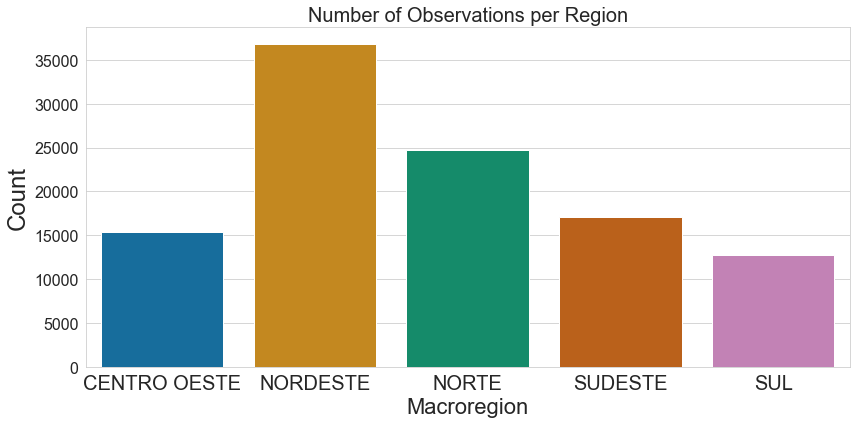

In [16]:
# Countplot of observations per Macroregion
count_plot("Macroregion", df, title="Number of Observations per Region", 
           xlabel='Macroregion', ylabel='Count', save_as=fig_path + "observations_per_region.png")

#### *State*

States are found within macroregions. The dataset has observations more or less evenly distributed across the *State* column, not the *Macroregion* column.

In [17]:
# Examine number of observations per state
df['State'].value_counts()

BAHIA                  4263
SAO PAULO              4263
PARAIBA                4263
CEARA                  4263
RIO DE JANEIRO         4263
RIO GRANDE DO SUL      4263
RIO GRANDE DO NORTE    4262
PERNAMBUCO             4262
SANTA CATARINA         4262
MINAS GERAIS           4261
ESPIRITO SANTO         4260
SERGIPE                4259
PARANA                 4251
ALAGOAS                4250
MATO GROSSO DO SUL     4246
MATO GROSSO            4037
AMAZONAS               3889
GOIAS                  3663
PIAUI                  3548
MARANHAO               3499
PARA                   3497
TOCANTINS              3483
DISTRITO FEDERAL       3483
ACRE                   3480
RONDONIA               3479
RORAIMA                3471
AMAPA                  3403
Name: State, dtype: int64

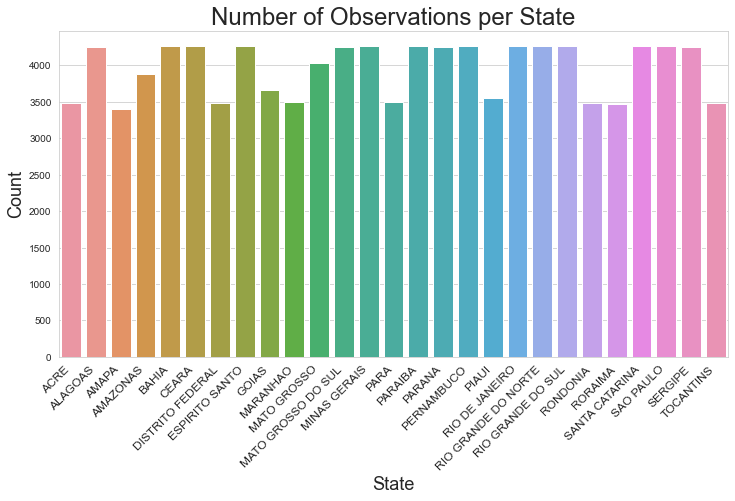

In [18]:
# Countplot of observations per State
fig, ax = plt.subplots(figsize=(12,6))
ax = sns.countplot(x="State", data=df)
plt.title("Number of Observations per State", fontsize=24)
plt.xlabel('State', fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.xticks(rotation=45, fontsize=12, ha='right')
plt.savefig(fig_path + 'observations_per_state.png', bbox_inches='tight')
plt.show()

#### *Product*

In [19]:
# Display percentages of products
df['Product'].value_counts(normalize=True)

PETROL             0.198403
DIESEL             0.198403
LPG                0.198328
HYDROUS ETHANOL    0.197542
NATURAL GAS        0.122015
DIESEL S10         0.085309
Name: Product, dtype: float64

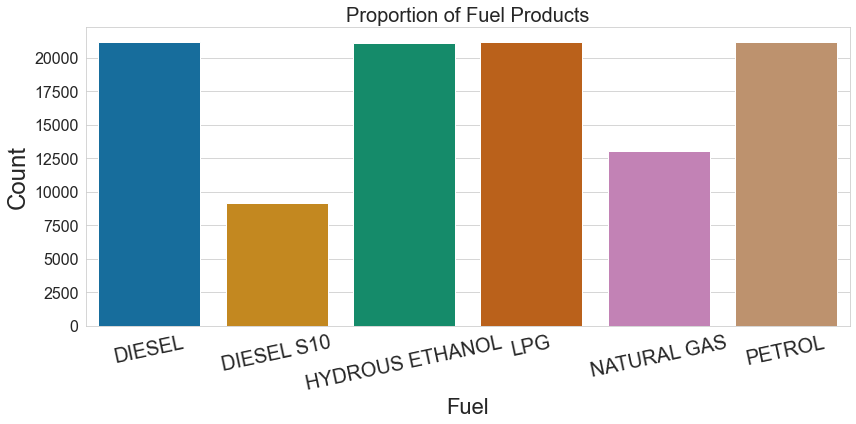

In [20]:
# Countplot of observations per fuel product
count_plot('Product', df, title="Proportion of Fuel Products", xlabel='Fuel', 
           ylabel='Count', rot=12, save_as=fig_path + 'observations_per_product.png')

Question: For which years do observations exist for each fuel type?

In [21]:
# Capture list of products
products = df.Product.unique().tolist()

fuel_years = pd.DataFrame()

product_group = df.groupby("Product")

# Extract first and last years of observation for each fuel product
for i, product in enumerate(products):
    
    df_temp = pd.DataFrame({"Product":product, "First_Year":product_group.get_group(product)["Year"].min(), 
                            "Last_Year":product_group.get_group(product)["Year"].max()}, index=[i])
    
    fuel_years = fuel_years.append(df_temp)
    
fuel_years.set_index("Product", inplace=True)

fuel_years

,First_Year,Last_Year
Product,,
HYDROUS ETHANOL,2004,2019
PETROL,2004,2019
LPG,2004,2019
NATURAL GAS,2004,2019
DIESEL,2004,2019
DIESEL S10,2012,2019


Notice that S10 DIESEL observations begin in 2012 while the others begin in 2004. 

Question: What is the proportion of fuel products observed in the dataset in each region?

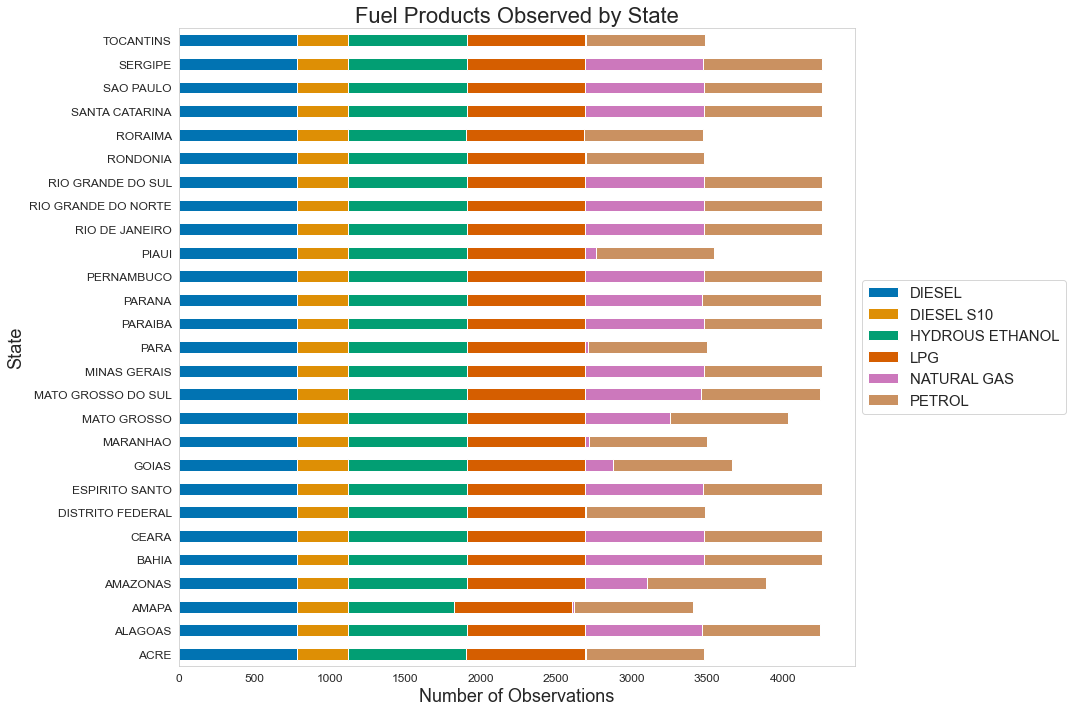

In [22]:
# Group by state
fuels_by_state = df.groupby("State")["Product"].value_counts().to_frame("Count").reset_index()
fuels_by_state = fuels_by_state.pivot("State", "Product")

fig, ax = plt.subplots(figsize=(15,10))

# Horizontal stacked bar chart
with sns.axes_style("white"):
    fuels_by_state.plot(kind="barh", stacked=True, ax=ax)

plt.title("Fuel Products Observed by State", fontsize=22)
plt.xlabel("Number of Observations", fontsize=18)
plt.ylabel("State", fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Sort order was confirmed before customizing legend
ax.legend(sorted(df.Product.unique().tolist()), loc='center left', bbox_to_anchor=(1, 0.5),prop={'size': 15})

plt.tight_layout()
plt.savefig(fig_path + 'observations_per_fuel_by_state.png', bbox_inches='tight')
plt.show()

#### *Measurement_unit*

Liquid fuels are measured in liters, LPG by 13kg cylinder, and Natural Gas by cubic meter.

In [23]:
df.Measurement_unit.value_counts(normalize=True)

liter    0.679657
13kg     0.198328
m3       0.122015
Name: Measurement_unit, dtype: float64

What is the proportion of each measurement unit within the dataset?

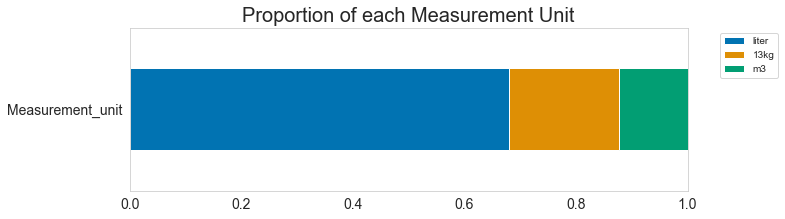

In [24]:
# Graph value counts

fig, ax = plt.subplots(1, 1, figsize=(10,3))

with sns.axes_style("white"):
    df.Measurement_unit.value_counts(normalize=True).to_frame("Measurement_unit").T.plot(kind="barh", stacked=True, ax=ax,
                                                    fontsize=14)

plt.legend(bbox_to_anchor=(1.05, 1))
plt.xlim(0, 1)
plt.title("Proportion of each Measurement Unit", fontsize=20)
plt.savefig(fig_path + 'barchart_unit_proportions.png', bbox_inches='tight')
plt.show()

#### *Price_Group*

Price Group 1 contains ethanol, petrol, diesel and gas, while Price Group 2 contains only LPG. We can also examine the proportion of each price group within the data.

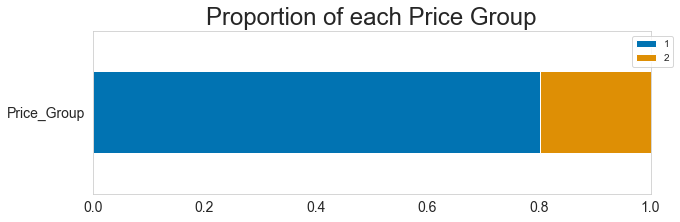

In [25]:
# Graph value counts

fig, ax = plt.subplots(1, 1, figsize=(10,3))

with sns.axes_style("white"):
    df.Price_Group.value_counts(normalize=True).to_frame("Price_Group").T.plot(kind="barh", stacked=True, ax=ax,
                                                    fontsize=14)

plt.legend(bbox_to_anchor=(1.05, 1))
plt.xlim(0, 1)
plt.title("Proportion of each Price Group", fontsize=24)
plt.savefig(fig_path + 'barchart_price_group_proportions.png', bbox_inches='tight')
plt.show()

#### 2.2.2 Numeric Variables

The numeric variables are:
* Analysis_Date
* No_of_Gas_Stations_Analyzed
* Mean_Price
* Mean_Dist_Price

#### *Analysis_Date*

This columns is a time unit going by week.

In [26]:
# Display count, start and end dates
count = len(df.Analysis_Date)
start = df.Analysis_Date.min().strftime('%Y-%m-%d')
end = df.Analysis_Date.max().strftime('%Y-%m-%d')

print("The are {} observations beginning on {} and ending {}".format(count, start, end))

The are 106823 observations beginning on 2004-05-09 and ending 2019-06-23


#### *No_of_Gas_Stations_Analyzed*

In [27]:
# Value counts by percentage
df.No_of_Gas_Stations_Analyzed.describe()

count    106823.000000
mean        233.770976
std         403.282519
min           1.000000
25%          42.000000
50%         104.000000
75%         243.000000
max        4167.000000
Name: No_of_Gas_Stations_Analyzed, dtype: float64

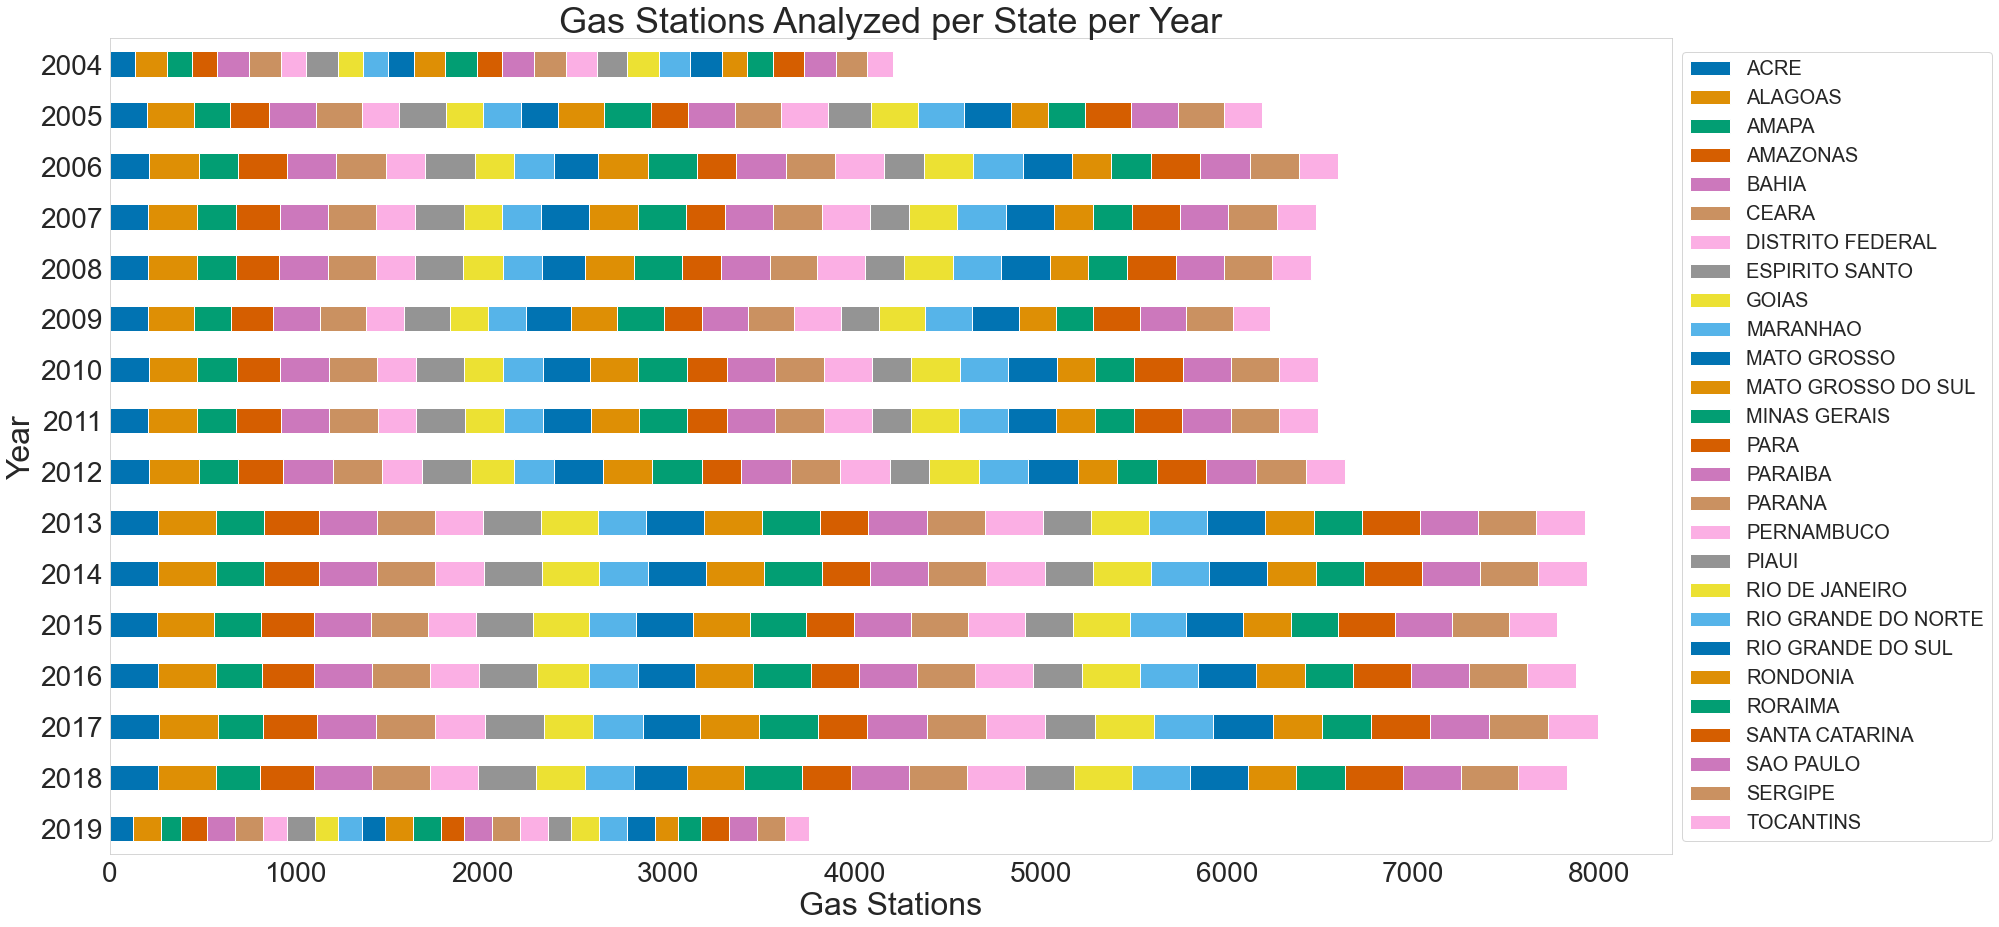

In [28]:
# Create graph of Gas Stations Analyzed per Year
gas_stations_by_year = df.groupby(["Year", "State"])[["No_of_Gas_Stations_Analyzed"]].count().reset_index()

fig, ax = plt.subplots(figsize=(28,15))

with sns.axes_style("white"):
    gas_stations_by_year.pivot("Year", "State").sort_values(by="Year", ascending=False).plot(kind="barh", stacked=True, ax=ax)

plt.title("Gas Stations Analyzed per State per Year", fontsize=36)
plt.xlabel("Gas Stations", fontsize=32)
plt.ylabel("Year", fontsize=32)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)

# Sort order was confirmed before customizing legend
ax.legend(sorted(gas_stations_by_year.State.unique().tolist()), loc='center left', 
          bbox_to_anchor=(1, 0.5), prop={'size': 20})

plt.savefig(fig_path + 'gas_stations_by_state_by_year.png', bbox_inches='tight')
plt.show()

#### *Mean_Price*

The average price paid by the customer at the pump. This is the main metric we are looking at in the analysis.

In [29]:
df.Mean_Price.describe()

count    106823.000000
mean         10.870780
std          17.752533
min           0.766000
25%           2.072000
50%           2.718000
75%           3.752000
max          99.357000
Name: Mean_Price, dtype: float64

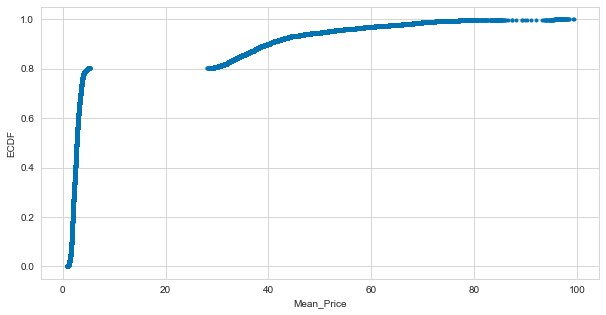

In [30]:
# Examine ecdf function on Mean_Price column
ecdf(df, 'Mean_Price')

The above ECDF plot tells us that the *Mean_Price* variable contains more than one distribution. The question is, what accounts for this? The answer is that each *Product* category has its own distribution, although several of them are in a similar price range.

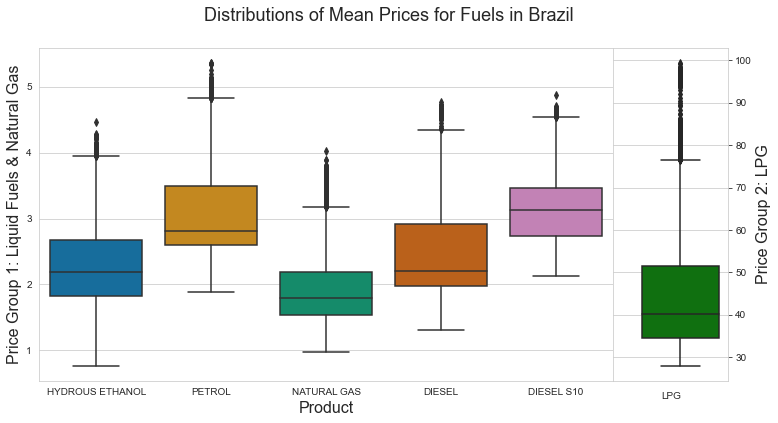

In [31]:
# Create a boxplot out of two separate axes with different scales
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6.5), gridspec_kw={"width_ratios":[5,1], "wspace":0})

# Axis for Products with similar means
sns.boxplot(x="Product", y="Mean_Price", data=df[df.Product!="LPG"], order=["HYDROUS ETHANOL", "PETROL", 
                                                              "NATURAL GAS", "DIESEL", "DIESEL S10"], 
            ax=ax[0])

# Axis for LPG
sns.boxplot(x="Product", y="Mean_Price", data=df[df.Product=="LPG"], ax=ax[1], color='g', width=4)

plt.suptitle("Distributions of Mean Prices for Fuels in Brazil", fontsize=18)

# Format LPG plot
ax[1].yaxis.tick_right()
ax[1].yaxis.set_label_position("right")
ax[0].set_xlabel('Product', fontsize=16)
ax[1].set_xlabel('LPG')
ax[0].set_ylabel('Price Group 1: Liquid Fuels & Natural Gas', fontsize=16)
ax[1].set_ylabel('Price Group 2: LPG', fontsize=16)
ax[1].set(xticklabels=[])


# Add subplot for LPG
plt.tight_layout(pad=5)

plt.savefig(fig_path + 'boxplot_mean_price.png', bbox_inches='tight')
plt.show()

Create separate *Mean_Price* ECDF plots for each fuel product:

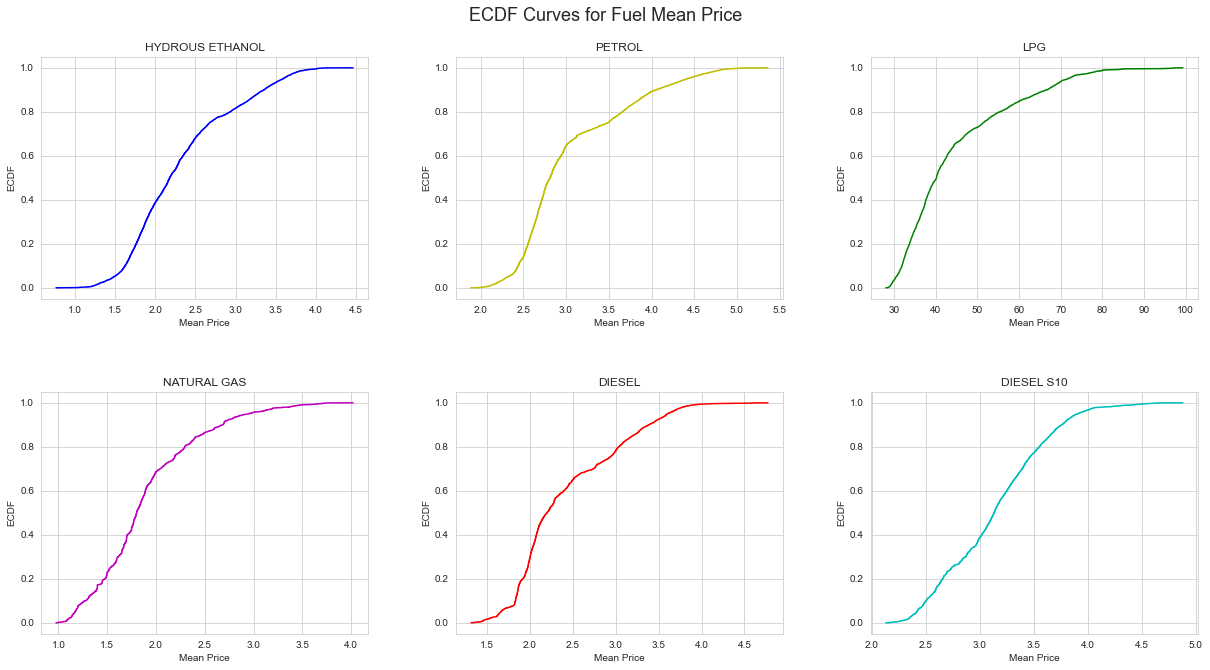

In [32]:
ecdf_category("Mean_Price", "Product", title="ECDF Curves for Fuel Mean Price", 
              xlabel="Mean Price", save_as=fig_path + 'ecdf_mean_price_by_product.png')

*Mean_Price* Time Series plots:

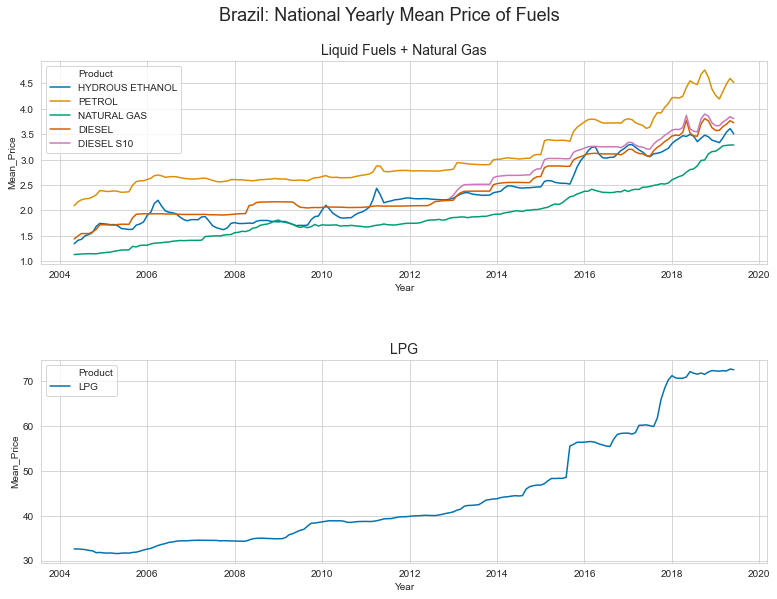

In [33]:
# Plot yearly Mean_Price
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12,9))

# Plot of fuels not including LPG
sns.lineplot(x="Year_Month", y="Mean_Price", data=df[df.Product!="LPG"], hue="Product", ax=ax[0], err_style=None)
ax[0].set_xlabel("Year")
ax[0].set_title("Liquid Fuels + Natural Gas", fontsize=14)

# Plot of LPG
sns.lineplot(x="Year_Month", y="Mean_Price", data=df[df.Product == "LPG"], hue="Product", ax=ax[1], err_style=None)
ax[1].set_xlabel("Year")
ax[1].set_title("LPG", fontsize=14)

plt.suptitle("Brazil: National Yearly Mean Price of Fuels", fontsize=18)
plt.tight_layout(pad=5)
plt.savefig(fig_path + 'timeseries_mean_price_by_year.png', bbox_inches='tight')
plt.show()

#### *Mean_Dist_Price*

The average wholesale price paid by supplier. While not being used in the analysis, it's included because of some interesting behavior it has:

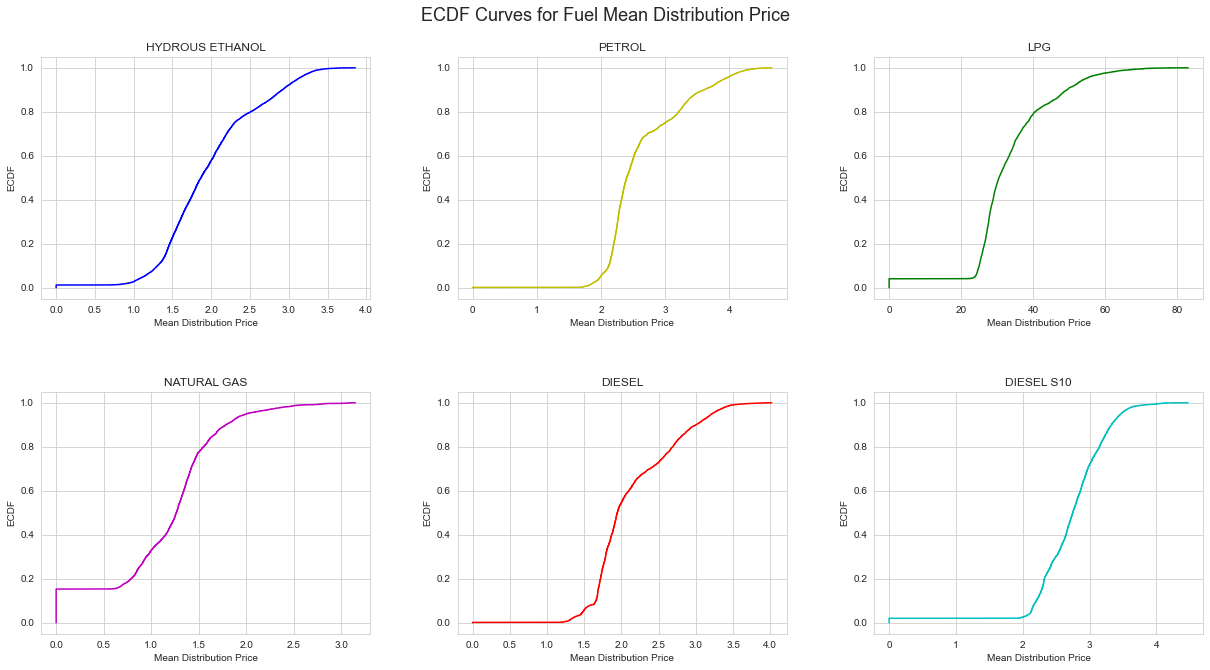

In [34]:
ecdf_category("Mean_Dist_Price", "Product", title="ECDF Curves for Fuel Mean Distribution Price", 
             xlabel="Mean Distribution Price", save_as=fig_path + 'ecdf_mean_dist_price_by_product.png')

Note the horizontal and vertical lines, what do these mean? It is possible there were price controls in effect for some fuels.

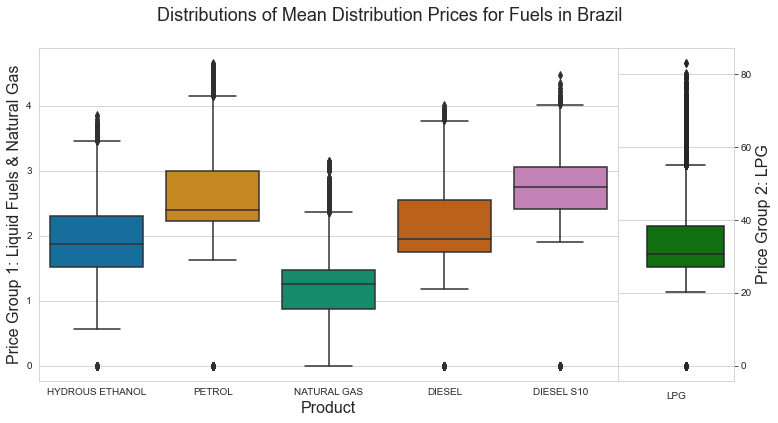

In [35]:
# Create a boxplot out of two separate axes with different scales
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6.5), gridspec_kw={"width_ratios":[5,1], "wspace":0})

# Axis for Products with similar means
sns.boxplot(x="Product", y="Mean_Dist_Price", data=df[df.Product!="LPG"], order=["HYDROUS ETHANOL", "PETROL", 
                                                              "NATURAL GAS", "DIESEL", "DIESEL S10"], 
            ax=ax[0])

# Axis for LPG
sns.boxplot(x="Product", y="Mean_Dist_Price", data=df[df.Product=="LPG"], ax=ax[1], color='g', width=4)

plt.suptitle("Distributions of Mean Distribution Prices for Fuels in Brazil", fontsize=18)

# Format LPG plot
ax[1].yaxis.tick_right()
ax[1].yaxis.set_label_position("right")
ax[0].set_xlabel('Product', fontsize=16)
ax[1].set_xlabel('LPG')
ax[0].set_ylabel('Price Group 1: Liquid Fuels & Natural Gas', fontsize=16)
ax[1].set_ylabel('Price Group 2: LPG', fontsize=16)
ax[1].set(xticklabels=[])


# Add subplot for LPG
plt.tight_layout(pad=5)

plt.savefig(fig_path + 'boxplot_mean_dist_price.png', bbox_inches='tight')
plt.show()

*Mean_Dist_Price* Time Series plots:

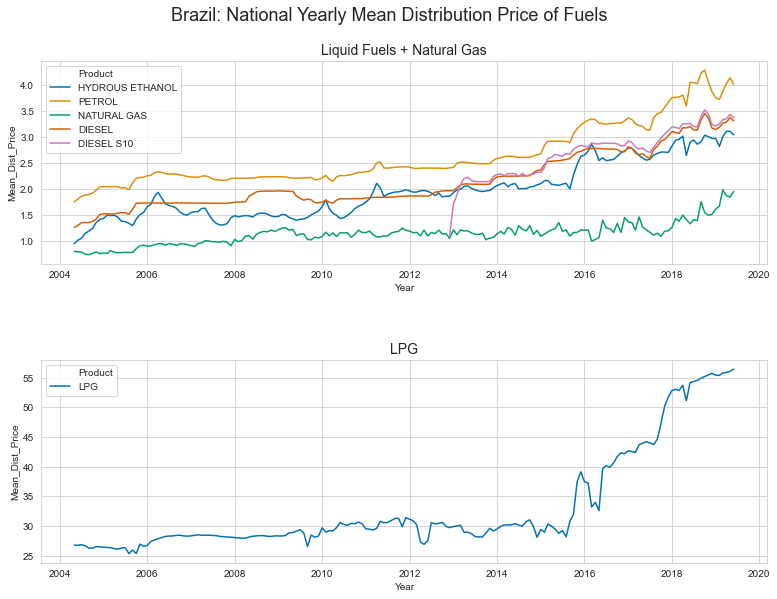

In [36]:
# Plot yearly Mean_Price
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12,9))

# Plot of fuels not including LPG
sns.lineplot(x="Year_Month", y="Mean_Dist_Price", data=df[df.Product!="LPG"], hue="Product", ax=ax[0], err_style=None)
ax[0].set_xlabel("Year")
ax[0].set_title("Liquid Fuels + Natural Gas", fontsize=14)

# Plot of LPG
sns.lineplot(x="Year_Month", y="Mean_Dist_Price", data=df[df.Product == "LPG"], hue="Product", ax=ax[1], err_style=None)
ax[1].set_xlabel("Year")
ax[1].set_title("LPG", fontsize=14)

plt.suptitle("Brazil: National Yearly Mean Distribution Price of Fuels", fontsize=18)
plt.tight_layout(pad=5)
plt.savefig(fig_path + 'timeseries_mean_dist_price_by_year.png', bbox_inches='tight')
plt.show()

## Conclusion

This concludes the exploratory analysis. A thorough report on the topic could include more quantitative analysis in addition to the graphs but for an initial exploration the visualizations give a good idea as to patterns and behavior of the data. The next step in this analysis would be to implement a data pipeline that can automatically process fresh data and output the charts for a report or website, as well as profile the code and find ways to make it run faster.